In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
from matplotlib import pyplot as plt
from datetime import timedelta
from torch.nn.parallel import DataParallel

df = pd.read_parquet('data/rucphen_precipitation.parquet')

In [2]:
def create_plot(df, x,xlabel, y, ylabel, title):
    # Create a line plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x = x, y = y)

    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Display the plot
    plt.show()
def show_df(df, start = pd.to_datetime('2020-02-01 08:00:00'), end = pd.to_datetime('2023-11-01 08:00:00')):
    # Define the start and end timestamps
    start_timestamp = start
    end_timestamp = end

    # Create a boolean mask for the specified time range
    mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    result_df = df[mask]

    create_plot(result_df, 'timestamp','Timestamp', 'precipitation','mm', 'Line Plot: Rainfall over time')
    create_plot(result_df, 'timestamp','Timestamp', 'percentage','%', 'Line Plot: Percentage full over time')


In [3]:
# show_df(df, pd.to_datetime('2020-06-01 08:00:00'), pd.to_datetime('2023-10-01 08:00:00'))

In [4]:
start_timestamp = pd.to_datetime('2021-01-01 08:00:00')
end_timestamp = pd.to_datetime('2022-12-01 08:00:00')

# Create a boolean mask for the specified time range
mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

# Apply the mask to get the desired slice of the DataFrame
df_reduced = df[mask]
df_reduced.fillna(0, inplace=True)
# show_df(df_reduced)

/tmp/ipykernel_3405283/983979855.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced.fillna(0, inplace=True)


In [5]:
def df_features_of_df(df: pd.DataFrame):
    # Datetime features
    # Extracting features
    df_features = df.copy()
    # df_features['percentage_delta'] = df_features['percentage'].diff()
    # df_features['percentage_delta'].fillna(0, inplace=True)
    # print(df_features)

    df_features['hour'] = df_features['timestamp'].dt.hour
    df_features['dayofweek'] = df_features['timestamp'].dt.hour
    df_features['month'] = df_features['timestamp'].dt.hour

    # Define the lags you want
    # precipitation_lags = [1, 2, 3, 4, 5, 6]
    # percentage_delta_lags = [1, 2, 3, 4]
    percentage_lags = [1, 2, 3, 4, 5, 6]

    # df_features['precipitation_0-30'] = df_features['precipitation'].rolling(6, min_periods=1).sum()
    df_features['precipitation_0-60'] = df_features['precipitation'].rolling(12, min_periods=1).sum()
    df_features['precipitation_60-120'] = df_features['precipitation'].shift(13).rolling(12, min_periods=1).sum()
    # df_features['precipitation_90-120'] = df_features['precipitation'].rolling(24, min_periods=1).sum()
    
    # df_features['percentage_0-30'] = df_features['precipitation'].rolling(6, min_periods=1).sum()
    df_features['percentage_30-60'] = df_features['percentage'].shift(7).rolling(6, min_periods=1).sum()
    df_features['percentage_60-90'] = df_features['percentage'].shift(13).rolling(6, min_periods=1).sum()
    # df_features['percentage_90-120'] = df_features['precipitation'].rolling(24, min_periods=1).sum()

    # df_features['precipitation_0-180'] = df_features['precipitation'].rolling(30, min_periods=1).sum()
    # df_features['precipitation_0-240'] = df_features['precipitation'].rolling(36, min_periods=1).sum()
    # df_features['percentage_0-30'] = df_features['percentage'].rolling(6, min_periods=1).sum()
    # df_features['percentage_delta_30-60'] = df_features['percentage_delta'].shift(5).rolling(8, min_periods=1).sum()
    # df_features['percentage_delta_60-90'] = df_features['percentage_delta'].shift(13).rolling(6, min_periods=1).sum()
    # df_features['percentage_delta_90-120'] = df_features['percentage_delta'].shift(19).rolling(6, min_periods=1).sum()

    # Add lag features for 'precipitation'
    # for lag in precipitation_lags:
    #     df_features[f'precipitation_lag_{lag}'] = df_features['precipitation'].shift(lag)

    # Add lag features for 'percentage_delta'
    # for lag in percentage_delta_lags:
    #     df_features[f'percentage_delta_lag_{lag}'] = df_features['percentage_delta'].shift(lag)

    # Add lag features for 'percentage'
    for lag in percentage_lags:
        df_features[f'percentage_lag_{lag}'] = df_features['percentage'].shift(lag)

    return df_features

In [6]:
df_features = df_features_of_df(df_reduced)
# Drop rows with NaN values introduced by the lag operation
df_features.dropna(inplace=True)

# Reset index to integers
df_features = df_features.reset_index(drop=True)
# df_features.head()

In [7]:
# Extract features and target from the DataFrame
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

X = df_features.copy()
# X.drop(columns=['timestamp', 'percentage', 'percentage_delta'], inplace=True)
# y = df_features['percentage_delta']

X.drop(columns=['timestamp', 'percentage'], inplace=True)
y = df_features['percentage']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy().reshape(-1, 1), test_size=0.5, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X, y.to_numpy().reshape(-1, 1), test_size=0.25, shuffle=False)

# Standardize Data
# class MinMaxPositiveScaler:
#     def __init__(self):
#         self.min_max_scaler = MinMaxScaler()

#     def fit(self, X):
#         self.min_max_scaler.fit(X)
#         return self

#     def transform(self, X):
#         scaled_data = self.min_max_scaler.transform(X)
#         shifted_data = scaled_data + abs(np.min(scaled_data)) # Shift to make all numbers positive
#         return shifted_data
    
#     def inverse_transform(self, X):
#         scaled_data = self.min_max_scaler.inverse_transform(X)
#         shifted_data = scaled_data - abs(np.min(scaled_data))  # Shift numbers back
#         return shifted_data

#     def fit_transform(self, X):
#         self.fit(X)
#         return self.transform(X)

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_val_scaled = scaler_X.transform(X_val)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
y_val_scaled = scaler_y.transform(y_val)

def scale_X(df: pd.DataFrame):
    return scaler_X.transform(df)
def scale_y(df: pd.DataFrame):
    return scaler_y.transform(df)

In [8]:
# print("Number of samples in X_train_scaled:", len(X_train_scaled))
# print("Number of samples in y_train:", len(y_train_scaled))
# print("Number of samples in X_test_scaled:", len(X_test_scaled))
# print("Number of samples in y_test:", len(y_test_scaled))

y_train

array([[2.632],
       [2.632],
       [2.632],
       ...,
       [0.   ],
       [0.   ],
       [0.   ]])

In [9]:
if torch.cuda.is_available():
    print("CUDA is available. GPU will be used.")
else:
    print("CUDA is not available. CPU will be used.")

if torch.distributed.is_available():
    print("Distributed is available")
else:
    print("Distributed is not available")
    

CUDA is available. GPU will be used.
Distributed is available


In [10]:
# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Define the PyTorch neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, activation_function):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.activation1 = self.get_activation(activation_function)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.activation2 = self.get_activation(activation_function)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.activation3 = self.get_activation(activation_function)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.activation2(self.fc2(x))
        x = self.activation3(self.fc3(x))
        x = self.fc4(x)
        return x

    def predict(self, X):
        """
        Make predictions using the trained model.

        Parameters:
            X (np.ndarray): Input data as a NumPy array.

        Returns:
            np.ndarray: Predicted output as a NumPy array.
        """
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to('cuda')  # Move input to GPU
            output = self(X_tensor)
        return output.cpu().numpy()  # Move output back to CPU and convert to NumPy array
    
    def get_activation(self, activation_function):
        if activation_function == 'relu':
            return nn.ReLU()
        elif activation_function == 'sigmoid':
            return nn.Sigmoid()
        elif activation_function == 'tanh':
            return nn.Tanh()
        elif activation_function == 'leaky_relu':
            return nn.LeakyReLU()
        else:
            raise ValueError(f"Unsupported activation function: {activation_function}")


# Define the PyTorch training function
def train_neural_network(trial, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, input_size, output_size):
    # torch.set_num_threads(5)
    hidden_size1 = trial.suggest_categorical('hidden_size1', [10, 13, 15, 20, 25, 30])
    hidden_size2 = trial.suggest_categorical('hidden_size2', [10, 13, 15, 20, 25, 30])
    hidden_size3 = trial.suggest_categorical('hidden_size3', [10, 13, 15, 20, 25, 30])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'leaky_relu'])

    model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, activation_function)
    model = DataParallel(model)  # Utilize multithreading on GPU
    model = model.to('cuda')
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled).to('cuda')
    y_train_tensor = torch.FloatTensor(y_train_scaled).to('cuda')
    X_val_tensor = torch.FloatTensor(X_val_scaled).to('cuda')
    y_val_tensor = torch.FloatTensor(y_val_scaled).to('cuda')

    # Define data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    # A batch of 2 days
    train_loader = DataLoader(train_dataset, batch_size=4032, shuffle=False)

    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=4032, shuffle=False)

    # Training loop
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_batch_loss = criterion(val_outputs, val_labels)
                val_loss += val_batch_loss
            
        # # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        
        # Report validation loss to Optuna
        trial.report(avg_val_loss, epoch)

        # Prune the trial if needed
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss.item()

# Define the Optuna objective function
def objective(trial):
    # Assuming X_train, y_train, X_val, y_val are already defined
    input_size = X_train.shape[1]
    output_size = 1  # Assuming a regression task with one output

    return train_neural_network(trial, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, input_size, output_size)

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are already defined
# Replace these with the actual data you have

# TimeSeriesSplit with 5 splits
# tscv = TimeSeriesSplit(n_splits=5)

# Split data into training and validation sets
# for train_idx, val_idx in tscv.split(X_train):
#     X_train, X_val = X_train[train_idx], X_train[val_idx]
#     y_train, y_val = y_train[train_idx], y_train[val_idx]

# Train the neural network using Optuna
train = False
if train:
    study = optuna.create_study(directions=['minimize'])
    study.optimize(objective, n_trials=200)
    
    # Get the best hyperparameters
    best_params = study.best_trial.params
    
    # Print the best parameters
    print(f"Best values: {study.best_trial.values} | best params: {best_params}")
    
    # Train PyTorch model with the best hyperparameters
    best_model = NeuralNetwork(X_train_scaled.shape[1], best_params['hidden_size1'], best_params['hidden_size2'], best_params['hidden_size3'], 1, best_params['activation_function'])
    # best_model = nn.DataParallel(model)
    best_model = best_model.to('cuda')
    criterion = nn.MSELoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    
    X_train_tensor = torch.FloatTensor(X_train_scaled).to('cuda')
    y_train_tensor = torch.FloatTensor(y_train_scaled).to('cuda')
    
    # Training loop
    for epoch in range(200):
        best_model.train()
        optimizer.zero_grad()
        outputs = best_model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    print('training done: saving model')
    # Save the PyTorch model
        # Save the PyTorch model and best hyperparameters
    torch.save({
        'model_state_dict': best_model.state_dict(),
        'best_params': {
            'hidden_size1': best_params['hidden_size1'],
            'hidden_size2': best_params['hidden_size2'],
            'hidden_size3': best_params['hidden_size3'],
            'learning_rate': best_params['learning_rate'],
            'activation_function': best_params['activation_function']
        }
    }, './models/pytorch_optuna_model.pth')
else:
    checkpoint = torch.load('./models/pytorch_optuna_model.pth')
    print(checkpoint)
    best_model = NeuralNetwork(X_train_scaled.shape[1], checkpoint['best_params']['hidden_size1'],
                               checkpoint['best_params']['hidden_size2'], checkpoint['best_params']['hidden_size3'], 1, checkpoint['best_params']['activation_function'])
    best_model.load_state_dict(checkpoint['model_state_dict'])
    best_model = best_model.to('cuda')

{'model_state_dict': OrderedDict([('fc1.weight', tensor([[ 1.3062e-01, -2.0708e-01, -6.3288e-02,  2.7465e-01,  3.6521e-01,
          4.3199e-01,  4.4299e-01,  2.1570e-02, -3.5348e-01, -1.6797e-01,
          2.7241e-01,  1.3867e-01,  5.4115e-01,  2.8262e-01],
        [ 1.4516e-01, -1.7423e-01, -1.6522e-02, -2.1059e-01, -8.7014e-03,
         -2.1437e-01,  6.5206e-02, -2.3876e-02,  3.4757e-01,  2.8987e-01,
         -9.9131e-02,  1.2263e-01,  1.1220e-01,  2.9878e-01],
        [ 9.4043e-03, -5.0884e-02, -1.5680e-01,  3.1954e-01,  2.1155e-01,
         -3.1282e-01,  3.8527e-01,  9.1557e-02, -2.8133e-01, -3.1333e-01,
         -1.2044e-01,  1.0118e-01, -6.7299e-02, -4.8959e-02],
        [-2.2502e-01,  3.6950e-01,  2.5799e-01, -1.5753e-01,  1.5856e-01,
         -4.2880e-01,  1.2329e-01, -1.5344e-03, -2.6062e-01,  5.3581e-02,
         -2.8115e-01,  7.2178e-02, -1.8172e-01, -2.7961e-01],
        [-2.5736e-01,  1.4659e-01, -1.4762e-01, -2.4258e-01,  6.4762e-02,
         -6.0899e-02, -1.2781e-01,  8

Mean Squared Error: 0.00013000296325786672
r2: 0.9969968120613809


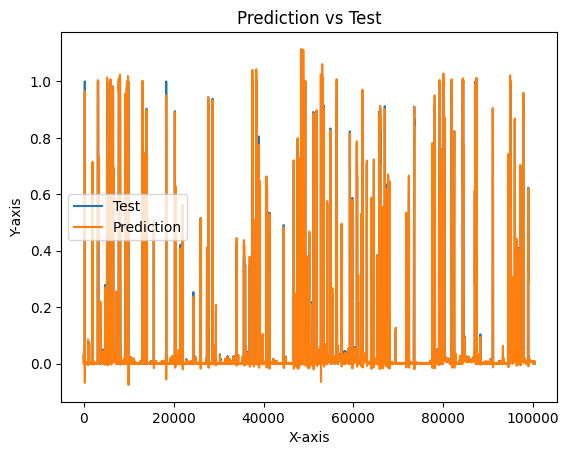

In [11]:
def predict(X_test_scaled, model):
    # Make Predictions
    return best_model.predict(X_test_scaled).reshape(-1, 1)

def evaluate(y_test, predictions):

    # # Use np.clip to limit values between 0 and 100
    # predictions_clipped = np.clip(predictions, 0, 100)

    # Evaluate the Model
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse.item()}')

    r2 = r2_score(y_test, predictions)
    print(f'r2: {r2.item()}')

    # Plotting
    plt.plot(y_test, label='Test')
    plt.plot(predictions, label='Prediction')

    # Adding labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Prediction vs Test')

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()

def predict_and_evaluate(X_test_scaled, y_test, model):
    predictions = predict(X_test_scaled, model)
    evaluate(y_test, predictions)

predict_and_evaluate(X_train_scaled, y_train_scaled, best_model)

In [12]:
y_pred = predict(X_test_scaled, best_model)
y_actual = scaler_y.inverse_transform(y_test)
y_pred = scaler_y.inverse_transform(y_pred)
df_pred = pd.DataFrame({'Actual': y_actual.flatten(), 'Prediction': y_pred.flatten()})

# Display the DataFrame
df_pred

,Actual,Prediction
0,263.2,2.236545
1,263.2,2.242109
2,263.2,2.170395
3,263.2,2.085496
4,263.2,2.044605
...,...,...
150519,263.2,1.278928
150520,263.2,1.278928
150521,263.2,1.278928
150522,263.2,1.278928


In [13]:
# def plot_importances(model, feature_names):
#     # Get feature importances from the model
#     importances = model.feature_importances_

#     # Sort indices and feature names
#     indices = np.argsort(importances)[::-1]
#     feature_names = [feature_names[i] for i in indices]

#     # Create a DataFrame for better visualization
#     df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances[indices]})

#     # Display the top 20 features
#     print(df_importances.head(20))

#     # Create a horizontal bar plot
#     plt.figure(figsize=(10, 8))
#     plt.barh(range(len(feature_names)), importances[indices], align='center')

#     # Set y-axis labels
#     plt.yticks(range(len(feature_names)), feature_names)

#     # Display the plot
#     plt.xlabel('Feature Importance')
#     plt.ylabel('Feature')
#     plt.title('Top 20 Feature Importances')
#     plt.show()

# # Assuming best_model is your trained XGBoost model and X is your feature matrix
# plot_importances(best_model, X.columns.tolist())


In [26]:
query_timestamp = pd.to_datetime('2021-01-01 08:00:00')
df_reduced.loc[df_reduced['timestamp'] == query_timestamp, 'percentage'].values[0]

0.0

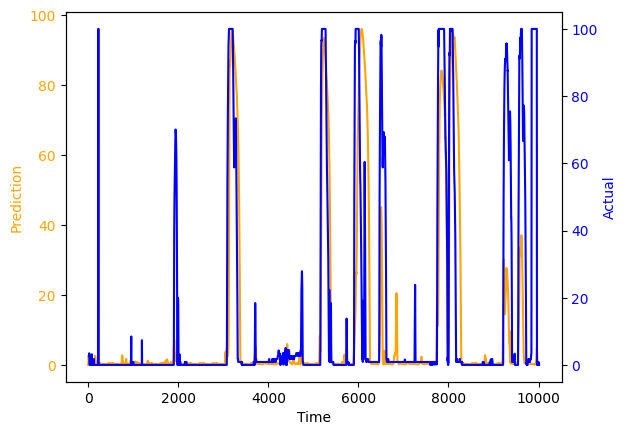

,timestamp,percentage,precipitation,actual_percentage,hour,dayofweek,month,precipitation_0-60,precipitation_60-120,percentage_30-60,percentage_60-90,percentage_lag_1,percentage_lag_2,percentage_lag_3,percentage_lag_4,percentage_lag_5,percentage_lag_6
0,2021-01-01 08:00:00,0.000000,0.000000,NaN,8,8,8,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 08:05:00,0.000000,0.000000,NaN,8,8,8,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 08:10:00,0.000000,0.000000,NaN,8,8,8,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
3,2021-01-01 08:15:00,0.000000,0.000000,NaN,8,8,8,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
4,2021-01-01 08:20:00,0.000000,0.000000,NaN,8,8,8,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10009,2021-02-05 02:05:00,0.277895,0.070007,0.0,2,2,2,0.150002,0.029999,2.760786,3.311292,0.485002,0.483266,0.479351,0.478246,0.470556,0.466619
10010,2021-02-05 02:10:00,0.328127,0.039993,0.0,2,2,2,0.189995,0.029999,2.748175,3.229436,0.277895,0.485002,0.483266,0.479351,0.478246,0.470556
10011,2021-02-05 02:15:00,0.347482,0.009995,0.0,2,2,2,0.199989,0.010002,2.749470,3.132737,0.328127,0.277895,0.485002,0.483266,0.479351,0.478246
10012,2021-02-05 02:20:00,0.385465,0.000000,0.0,2,2,2,0.199989,0.000000,2.785799,3.012168,0.347482,0.328127,0.277895,0.485002,0.483266,0.479351


In [38]:
def predict_one_step(X_test:pd.DataFrame, X_weather:pd.DataFrame):
    # X_test_filtered = X_test.drop(columns=['percentage_delta', 'percentage', 'timestamp'])
    X_test_filtered = X_test.drop(columns=['percentage', 'timestamp', 'actual_percentage'])
    X_test_scaled = scale_X(X_test_filtered.tail(1))
    input = X_test.tail(1)

    percentage = scaler_y.inverse_transform(predict(X_test_scaled, best_model)[0].reshape(-1, 1))[0][0]

    # print('here', percentage_delta_clipped)

    future_timestamp = input['timestamp'].values[0] + np.timedelta64(5, 'm')
    precipitation_row = X_weather[future_timestamp == X_weather['timestamp']].iloc[0]
    actual_percentage = result_percentage = df_reduced.loc[df_reduced['timestamp'] == future_timestamp, 'percentage'].values[0]

    new_row = {
        'timestamp':future_timestamp,
        'precipitation': precipitation_row['precipitation'],
        # 'percentage_delta': percentage_delta,
        # 'percentage': input['percentage'].values[0] + percentage_delta
        'percentage': percentage,
        'actual_percentage': actual_percentage
        }
    # df_unprocessed = pd.concat([X_test[['timestamp', 'percentage', 'percentage_delta', 'precipitation' ]], pd.DataFrame([new_row])], ignore_index=True)
    df_unprocessed = pd.concat([X_test[['timestamp', 'percentage', 'precipitation', 'actual_percentage']], pd.DataFrame([new_row])], ignore_index=True)
    return df_features_of_df(df_unprocessed)
    
X_original = df_features_of_df(df_reduced)
first_nan_index = X_original['precipitation_60-120'].notna().idxmax()
X_result = X_original.copy()
X_result = X_result[X_result.index <= first_nan_index]
X_result['actual_percentage'] = np.nan
# int(len(X_original)/2)
for i in range(0,10000):
    X_result = predict_one_step(X_result,X_original)

# X_result[['percentage_delta', 'precipitation']].plot()

X_plotted = X_result
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time') 
ax1.set_ylabel('Prediction', color='orange') 
ax1.plot(X_plotted.index, X_plotted['percentage'], color='orange') 
ax1.tick_params(axis='y', labelcolor='orange') 

# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('Actual', color='blue') 
ax2.plot(X_plotted.index, X_plotted['actual_percentage'], color='blue') 
ax2.tick_params(axis='y', labelcolor='blue') 

# Show plot
plt.show()

# X_result[['percentage', 'precipitation']].plot()
X_plotted

In [41]:
from sklearn.metrics import mean_absolute_error
# Evaluate the Model
X_no_nan = X_result.dropna()

mse = mean_squared_error(X_no_nan['percentage'], X_no_nan['actual_percentage'])
print(f'Mean Squared Error: {mse.item()}')

mae = mean_absolute_error(X_no_nan['percentage'], X_no_nan['actual_percentage'])
print(f'Mean Absolute Error: {mae.item()}')

r2 = r2_score(X_no_nan['percentage'], X_no_nan['actual_percentage'])
print(f'r2: {r2.item()}')

Mean Squared Error: 616.2660455702141
Mean Absolute Error: 10.431114488130403
r2: 0.0433092640983217
